In [2]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo
import FwtModels as mf

me.mechanics_printing()

#### Define our Constants
first step is to define our constants / parameters

In [8]:
DoFs = 2

# heave and fold angle as degrres of freedom
p = ma.DynamicModelParameters(DoFs)

## Create some global parameters
p.m_1 = ma.ModelSymbol(value = 0.3,string = 'm_1')
p.m_2 = ma.ModelSymbol(value = 0.3,string = 'm_2')

# Inner Wing stiffness Properties
p.K = ma.ModelSymbol(value = 100,string = 'K') # Bending stiffness for the wing

# length of pendulum
p.L = ma.ModelSymbol(value = 0.3,string = 'L')

## Aero Parameters
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value =[0,0,-1],length=3,string='g_v') # The stationary point

## Numeric Model Constants
p.fp = ma.ModelMatrix(value =[0]*p.qs*2,length=p.qs*2,string='fp') # The stationary point

#### Our degrees of freedom are

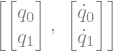

In [9]:
[p.q,p.qd]

## Define the Location of the top of the spring and the Mass of the Pendulum

In [10]:
#define refernce frames
spring_frame = ma.HomogenousTransform().Translate(0,0,p.q[0])
pendulum_frame = spring_frame.R_x(p.q[-1]).Translate(0,p.L,0)

Location at top of spring

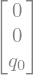

In [18]:
spring_frame.Transform_point([0,0,0])

Location of Pendulum mass

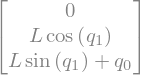

In [19]:
pendulum_frame.Transform_point([0,0,0])

### Define Potential and Kinetic energies

In [21]:
#Create Elemnts
ele_spring = ele.Spring(p.q[0],p.K)
spring_mass = ele.RigidElement.point_mass(spring_frame,p.m_1,True)
pendulum_ele = ele.RigidElement.point_mass(pendulum_frame,p.m_2,True)

#### spring potential energy

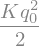

In [26]:
ele_spring.calc_pe(p)

In [28]:
pendulum_ele.calc_pe(p)

In [29]:
spring_mass.calc_pe(p)

In [5]:
Q = ef.BodyForce(p,fwt_com_frame,simplify=False)

In [6]:
# Create the SYmbolic Model
sm = ma.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele,fwt_ele,M_k],Q)

0
1
2


In [7]:
t = me.dynamicsymbols._t
theta = sym.Function('theta')(t)
h = sym.Function('h')(t)
qs = [h,theta]
# list(enumerate(qs))
subs = {**{p.q[i]:item for i,item in enumerate(qs)},**{p.qd[i]:item.diff(t) for i,item in enumerate(qs)}}
subs = {**subs,**{i:j for i,j in zip(p.g_v,p.g_v.value)}}

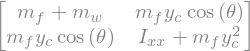

In [8]:
me.msubs(sm.M,subs)

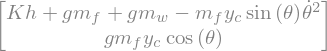

In [9]:
me.msubs(sm.f,subs)

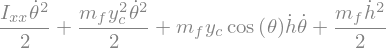

In [10]:
me.msubs(fwt_ele.calc_ke(p),subs)

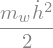

In [11]:
me.msubs(inner_wing_ele.calc_ke(p),subs)

In [12]:
me.msubs(inner_wing_ele.calc_pe(p),subs)

In [13]:
me.msubs(fwt_ele.calc_pe(p),subs)

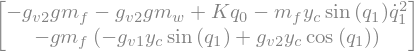

In [14]:
sm.f

In [22]:
sm.ExtForces.Q()

In [15]:
sm.to_matlab_file(p,'C:/Git/fwt_auto/test/')

TypeError: 'Symbol' object is not iterable

In [18]:
sm_lin = sm.linearise(p)
sm_lin.to_matlab_file_linear(p,'C:/Git/fwt_auto/model_2DoF/')

TypeError: object of type 'Symbol' has no len()

In [15]:
sm_lin.ExtForces.Q().jacobian(p.qd).shape